In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from control import * 
import gym
import sys

%matplotlib inline
init_printing(use_latex='mathjax')

In [2]:
def discretize(x):
    bins = np.array([
        [-3,-2],
        [-2,-1],
        [-1,-0.1],
        [-0.1,0.1],
        [0.1,1],
        [1,2],
        [2,3]
    ])
    if x < bins[0][0]:
        return 0
    for i in range(len(bins)):
        if bins[i][0] <= x and x < bins[i][1]:
            return i+1
    return len(bins)+1

def normalize_policy(pi):
    return [p/sum(p) for p in pi]

def choose_action(probs):
    r = np.random.rand()
    i = 0
    s = probs[0]
    while r >= s and i < len(probs)-1:
        s = s + probs[i]        
        i = i + 1
    return i

def sample(pi):
    x = 50*np.random.rand() - 25
    xdata = np.array([])
    adata = np.array([])
    for i in range(20):
        xd = discretize(x)
        a = np.random.normal(pi[xd][0],pi[xd][1])
        xdata = np.append(xdata,x)
        adata = np.append(adata,a)
        x = 1.1*x + a

    return np.transpose([xdata,adata])

def reward(x):
    return 1/(1+np.abs(x))

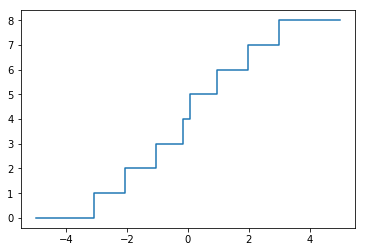

In [3]:
x = np.linspace(-5,5,100)
y = [discretize(a) for a in x]
plt.step(x,y);

In [4]:
states = [-1,0,1,2,3,4,5,6,7]

In [5]:
var("m v X")

nd = exp(
    (-(X-m)**2)/(2*v**2)
)/sqrt(2*pi*v**2)

diff(log(nd),m).simplify(), diff(log(nd),v).simplify()

⎛          2          2⎞
⎜X - m  - v  + (X - m) ⎟
⎜─────, ───────────────⎟
⎜   2           3      ⎟
⎝  v           v       ⎠

In [6]:
def logdN(q,a):
    mu,s = q
    return [
        1*(a-mu)/(s**2),
        0.1*(-s**2+(a-mu)**2)/(s**3)
    ]

2.19080309623992

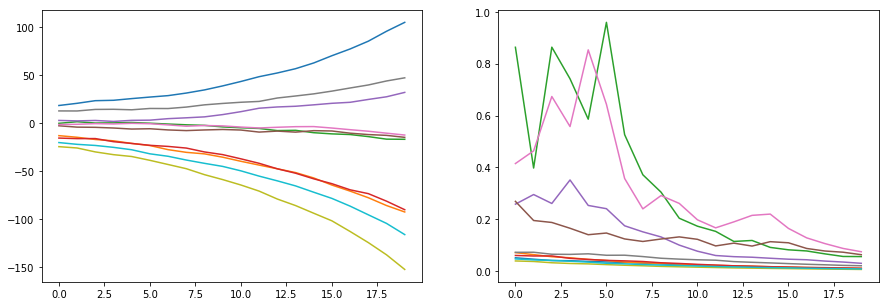

In [7]:
# Random initial policy
pol0 = np.transpose([0+0*np.random.rand(len(states)), 1+0*np.random.rand(len(states))])

samples = [sample(pol0) for i in range(10)]
fig,ax = plt.subplots(1,2,figsize=(15,5))
[ax[0].plot(s[:,0])  for s in samples];
[ax[1].plot(reward(s[:,0])) for s in samples];
sum([sum(reward(s[:,0])) for s in samples])/10

Step 499, Reward: 10.774873

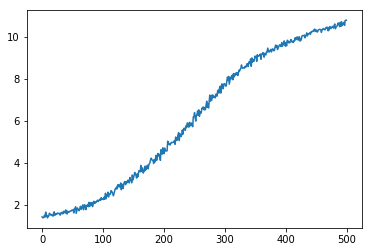

In [8]:
pol = pol0

data = np.array([])
n = 1000
rate = 0.01

for epoch in range(500):  
    
    samples = [sample(pol) for i in range(n)]
    dq = np.zeros([len(states),2])
    avg = 0
    
    epoch_reward = sum([sum(reward(s[:,0])) for s in samples])/n
    
    for s in samples:

        R = sum(reward(s[:,0]))
        avg += R

        for t in range(len(s)): # time
            xd = discretize(s[t,0])
            r = sum(reward(s[t:,0]))
            dq[xd] = dq[xd] + np.array(logdN(pol[xd],s[t,1])) * ( r - epoch_reward )

    sys.stdout.write("\rStep %d, Reward: %lf" % (epoch,epoch_reward))
    data = np.append(data,avg/len(samples))
    dq = dq / n
    pol = pol + rate * dq
    
    for j in range(len(states)):
        if pol[j,1] < 0.001:
            pol[j,1] = 0.001

plt.plot(data);

(0.0, 1.0, 0.0, 1.0)

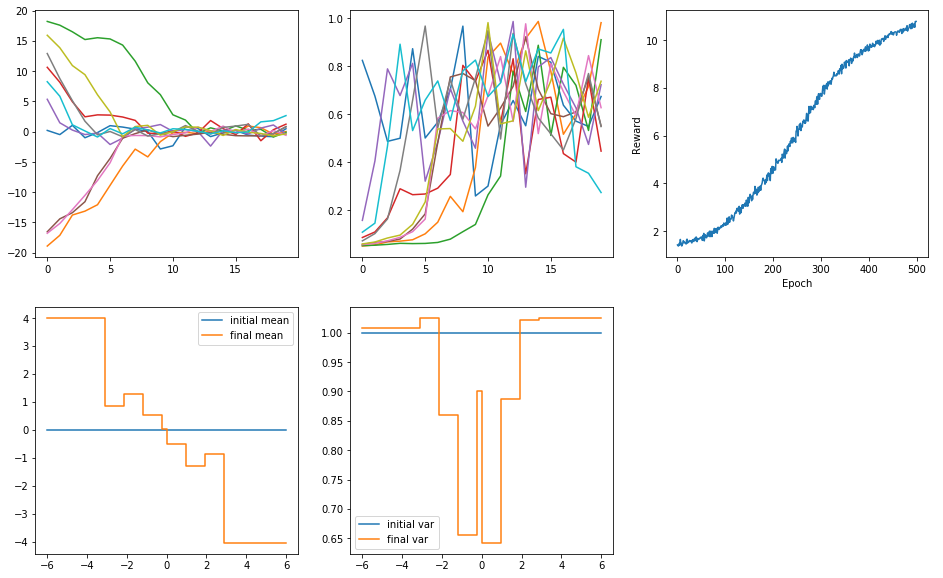

In [9]:
samples = [sample(pol) for i in range(10)]

fig,ax = plt.subplots(2,3,figsize=(16,10))

[ax[0,0].plot(s[:,0]) for s in samples];
[ax[0,1].plot(reward(s[:,0])) for s in samples];

x = np.linspace(-6,6,51)

y0 = [pol0[:,0][discretize(v)] for v in x]
yf = [pol[:,0][discretize(v)] for v in x]
ax[1,0].step(x,y0,label="initial mean");
ax[1,0].step(x,yf,label="final mean");
ax[1,0].legend();

y0 = [pol0[:,1][discretize(v)] for v in x]
yf = [pol[:,1][discretize(v)] for v in x]
ax[1,1].step(x,y0,label="initial var");
ax[1,1].step(x,yf,label="final var");
ax[1,1].legend();

ax[0,2].plot(data);
ax[0,2].set_xlabel("Epoch")
ax[0,2].set_ylabel("Reward")

ax[1,2].axis("off")